In [1]:
import rosbag
import glob
from urdf_parser_py.urdf import URDF
from pykdl_utils.kdl_parser import kdl_tree_from_urdf_model
from pykdl_utils.kdl_kinematics import KDLKinematics
import random
import cv2
from sensor_msgs.msg import Image
from cv_bridge import CvBridge, CvBridgeError
import os
from sklearn.neighbors import NearestNeighbors
from scipy import interpolate
from scipy.spatial import distance
import numpy as np
from numpy import linalg
%matplotlib inline
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

In [2]:
###ICP Transformations for each dataset
icpT0 = np.array([[ 0.98406577, -0.17605702, -0.02486944, -0.03333903],
       [ 0.17543957,  0.98416865, -0.02516012, -0.05192581],
       [ 0.02890534,  0.02039613,  0.99937404, -0.00247042],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])
icpT1 = np.array([[ 0.99756793, -0.06604025, -0.02229153,  0.01657539],
       [ 0.06540669,  0.99746448, -0.02804589,  0.00221307],
       [ 0.02408717,  0.02651967,  0.99935805, -0.02207707],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])
icpT2 = np.array([[ 0.99514554,  0.07030253, -0.06886884,  0.03592206],
       [-0.07141937,  0.99734968, -0.0138882 ,  0.04100649],
       [ 0.06770994,  0.01873935,  0.99752905, -0.03946576],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

icpT3 = np.array([[ 0.99795563,  0.05998181,  0.02206227, -0.02395778],
       [-0.06079507,  0.99741706,  0.03825128,  0.01230286],
       [-0.0197109 , -0.03951436,  0.99902457,  0.00191035],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])
icpT4 = np.array([[ 0.98158865,  0.13226293, -0.13780505,  0.03505378],
       [-0.13742645,  0.99009864, -0.02861209,  0.05712028],
       [ 0.13265627,  0.04702337,  0.99004602, -0.06572076],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])
icpT5 = np.array([[ 0.99049071,  0.11423248,  0.0766753 , -0.07531768],
       [-0.11544176,  0.99324751,  0.01151441,  0.03490833],
       [-0.07484223, -0.02025645,  0.99698963,  0.03980969],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])
icpT6 = np.array([[ 0.98545898,  0.11969865,  0.12059367, -0.04643522],
       [-0.11998926,  0.99276322, -0.00487528,  0.04724059],
       [-0.12030453, -0.00966555,  0.99268998,  0.02862556],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])
icpT7 = np.array([[ 9.75727610e-01,  2.15150772e-01, -4.08139256e-02,
         1.37626506e-05],
       [-2.15115481e-01,  9.76574201e-01,  5.30649122e-03,
         6.80338139e-02],
       [ 4.09995225e-02,  3.60201724e-03,  9.99152673e-01,
        -3.05080787e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])
icpT8 = np.array([[ 0.99950484, -0.02120508, -0.02324699, -0.01791566],
       [ 0.02075214,  0.99959339, -0.01955492, -0.0023119 ],
       [ 0.0236522 ,  0.01906281,  0.99953848, -0.0082203 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [3]:
data_path = './Robot_ViconNovember/'
folder = './images/'
viconfile = './Robot_ViconNovember/VD/D4.bag'
robotfile = './Robot_ViconNovember/RD/D4.bag'
vdbag = rosbag.Bag(viconfile)
rdbag = rosbag.Bag(robotfile)

vicon_dynaXpos = []
vicon_dynaYpos = []
vicon_dynaZpos = []
viconbag_time_dyna = []

#####Extracting the vicon pose from the data
for topicc, msgg, tt in vdbag.read_messages(topics=['/vicon/PEE/PEE']): 
    vicon_dynaXpos.append(msgg.transform.translation.x)
    vicon_dynaYpos.append(msgg.transform.translation.y)
    vicon_dynaZpos.append(msgg.transform.translation.z) 
    vicon_time_dy = tt.secs
    viconbag_time_dyna.append(vicon_time_dy)

vicon_dynaXPosArr = np.array(vicon_dynaXpos)
vicon_dynaYPosArr = np.array(vicon_dynaYpos)
vicon_dynaZPosArr = np.array(vicon_dynaZpos)
vicon_dynaPosArr = np.column_stack((vicon_dynaXPosArr,vicon_dynaYPosArr,vicon_dynaZPosArr)) 

robot_dynaXpos = []
robot_dynaYpos = []
robot_dynaZpos = []
robotbag_Tagtime_dyna = []  
#####Extracting April tag pose(camera) from the robot data
for topi, msgs, tym in rdbag.read_messages(topics=['/tag_detections']):
    try:
        robot_dynaXpos.append(msgs.detections[0].pose.pose.pose.position.x)
        robot_dynaYpos.append(msgs.detections[0].pose.pose.pose.position.y)
        robot_dynaZpos.append(msgs.detections[0].pose.pose.pose.position.z)   
        robotbag_Tagtime_dyna.append(tym.secs)
        
    except:
        continue
robot_dynaXposArr = np.array(robot_dynaXpos)
robot_dynaYposArr = np.array(robot_dynaYpos)
robot_dynaZposArr = np.array(robot_dynaZpos)
robot_dynaposArr = np.column_stack((robot_dynaXposArr,robot_dynaYposArr,robot_dynaZposArr))

#####Extracting robot joint angles and timestamps from the robot data    
robotbag_Jointstime_dyna = []
ja_list = []
ja_turretCam = []
for topic2, msg2, t2 in rdbag.read_messages(topics=['/Packbot510/joints']):
    ja_list.append(msg2.position[:4])
    ja_turretCam.append(msg2.position[8]) # extracting turretcam only
    robotbag_Jointstime_dyna.append(t2.secs)
ja_array_dyna = np.array(ja_list)
ja_turretCam_dyna = np.array(ja_turretCam)

#####Extracting April tag image(camera) from the robot data
bridge = CvBridge()
count = 0
tag_imagesTime = []
for topic, msg, tym in rdbag.read_messages(topics=['/tag_detections_image']):
    tag_imagesTime.append(tym.secs)
    cv_img = bridge.imgmsg_to_cv2(msg, desired_encoding="bgr8")
    cv2.imwrite(os.path.join(data_path+folder, "frame_{%d}.png" % count), cv_img)
    count += 1
#     for n in range(0, len(tag_imagesTime)):
#     # other things you need to do snipped
#     cv2.imwrite(f'data_path+folder/image_{n}.png',image)

    
#####Extracting camera info topic to get camera matrix from the camera data    
for topi, msgs, tym in rdbag.read_messages(topics=['/Zimmie/camera_info']): 
        camera_matrix = msgs.K
rdbag.close()

In [4]:
# for n in range(5):
#     print(f "filename_{n:04}.png") 

In [5]:
X_vicon = vicon_dynaPosArr
t_vicon = viconbag_time_dyna

theta_robot = ja_array_dyna
t_theta = robotbag_Jointstime_dyna

theta_turret = ja_turretCam_dyna

X_marker = robot_dynaposArr
t_marker = np.asanyarray(robotbag_Tagtime_dyna)

theta_cam = np.stack((theta_robot[:,0],theta_turret)).T

icpT = icpT1

In [6]:
#manually aligning the vicon data to robot frame
def manual_alignAndICP(X,ICPTrans4m):
    # initial manual
    th = np.radians(269)
    
    t = [0.00,0.004,0.005]
    R = np.array([[np.cos(th), -np.sin(th), 0],[np.sin(th), np.cos(th), 0],[0,0,1]])
    
    X_m = np.dot(R,X.T).T - t
    
    X_m_h = np.c_[X_m, np.ones(X_m.shape[0])] 
    X_m_trans = np.dot(ICPTrans4m,X_m_h.T).T
    X_m = X_m_trans[:,:3]
    return X_m

In [7]:
# Interpolate vicon
X_v = np.zeros((t_marker.shape[0],X_vicon.shape[1]))
for j in range(X_vicon.shape[1]):
    f = interpolate.interp1d(t_vicon, X_vicon[:,j], kind='nearest',fill_value="extrapolate")
    X_v[:,j] = f(t_marker)
X_v = (manual_alignAndICP(X_v,icpT))
    
# Interpolate theta_robot
th_r = np.zeros((t_marker.shape[0],theta_robot.shape[1]))
for j in range(theta_robot.shape[1]):
    f = interpolate.interp1d(t_theta, theta_robot[:,j], kind='nearest',fill_value="extrapolate")
    th_r[:,j] = f(t_marker)
    
# Interpolate theta_camera
th_c = np.zeros((t_marker.shape[0],theta_cam.shape[1]))
for j in range(theta_cam.shape[1]):
    f = interpolate.interp1d(t_theta, theta_cam[:,j], kind='nearest',fill_value="extrapolate")
    th_c[:,j] = f(t_marker)

In [8]:
# Create robot class for forward kinematics 
class Robot:
    def __init__(self,model_path):
        robot = URDF.from_xml_file(model_path)
        self.kdl = KDLKinematics(robot,'base_link','marker_link')
        self.kdl_turret = KDLKinematics(robot,'base_link','turret_camera_link')
        
    def fk(self,theta):
        return self.kdl.forward(theta)
    
    #computing the camera transformation from the base to the turretCam_link 
    def turretTransform(self,theta):
        return self.kdl_turret.forward(theta)
    

In [9]:
# Create procrustes function to use later
def procrustes(matx1,matx2):

    # translate all the data to the origin
    mean1 =  np.mean(matx1, 0)
    mean2 =  np.mean(matx2, 0)
    matx1 -= mean1
    matx2 -= mean2

    norm1 = np.linalg.norm(matx1)
    norm2 = np.linalg.norm(matx2)

    # change scaling of data (in rows) such that trace(mtx*mtx') = 1
    matx1 /= norm1
    matx2 /= norm2

    L,D,M = np.linalg.svd(matx1.T.dot(matx2))
    
    s = 1

    Rot = L.dot(M)
    tra = mean1 - (np.dot(Rot,mean2.T)).T

    return Rot, tra.reshape(-1,1)

In [10]:
#this one is for the fk 3d model outside the class
robot = Robot(data_path+'robotMarker.urdf')

In [11]:
# Forward kinematics for sanity check
X_fk = (np.hstack([robot.fk(th_r[i,:])[0:3,3] for i in range(th_r.shape[0])]).T)

In [12]:
# Get marker in base frame
X_marker_base = []
for t in range(th_r.shape[0]):
    
    camera_angle = th_c[t,:]
    marker_pos = X_marker[t,:]
        
    camHTH = robot.turretTransform(camera_angle)
    X_marker_base.append(np.linalg.inv(camHTH).dot(np.hstack((marker_pos,1)))[:,:3])
    
#camHTH is mapping from base to turret_link, not camera frame
# Rcam, tcam is rigid mapping from turret to data frame
X_marker_base = np.vstack(X_marker_base)

Rcam,tcam = procrustes(X_fk.copy(),X_marker_base.copy())
X_marker_new = (Rcam.dot(X_marker_base.T) + tcam).T

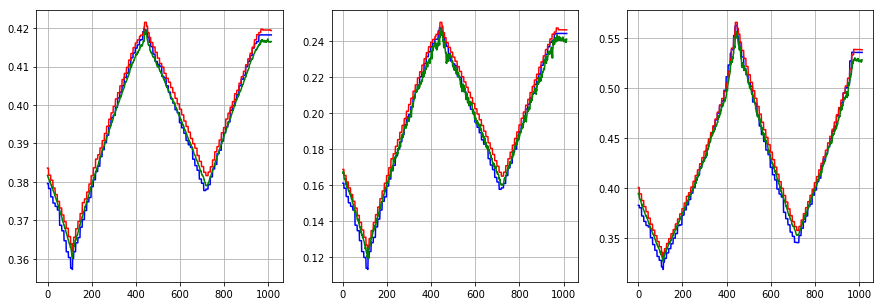

In [13]:
# Sanity check on alignment
plt.figure(figsize=(15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(X_fk[:,i][300:],c='b')
    plt.plot(X_v[:,i][300:],c='r')
    plt.plot(X_marker_new[:,i][300:],c='g')
    #plt.ylim(0,1)
    plt.grid()
plt.show()

In [14]:
def sigma_points(mu,cov,n,lam):
#computes the cholesky decomposition of matrix square root A, 
#which assumes it to be a symmetric and positive definite matrix
    chol_A = np.linalg.cholesky((n+lam)*cov)
    sigma_pointx = np.zeros((7,len(mu)))
    sigma_pointx[0,:] = mu
    for i in range(3):
        #print(i)
        sigma_pointx[i+1,:] =  mu + chol_A[:,i]
    for i in range(3):
        sigma_pointx[i+4,:] =  mu - chol_A[:,i]
    return sigma_pointx

In [15]:
#assigning weights to the computed sigmas
def weight_sigma(al,n,k,b,lam):
    c = n + lam
    w_mu = np.zeros((2 * n + 1,1))
    w_mu[0,0] = lam / c
    
    w_cov = np.zeros((2 * n + 1,1))
    w_cov[0,0] = w_mu[0,0] + (1 - al**2 + b)
    for i in range(6):
        w_mu[i+1,0] = 0.5/c
        w_cov[i+1,0] = 0.5/c
    return w_mu,w_cov

In [16]:
#estimating the resulting posterior distribution of the end-effector.
def estimate_distri(transformedpoints,weight_mean,weight_cov,n,resh):
    mu_Keeprime = np.zeros((resh,1))
    cov_Keeprime = np.zeros((resh,resh))
    for i in range(2*(n) + 1):
        mu_Keeprime = mu_Keeprime + weight_mean[i]*transformedpoints[i,:].reshape(resh,1)
    for i in range(2*(n) + 1):
        cov_Keeprime = cov_Keeprime + weight_cov[i]*(transformedpoints[i,:].reshape(resh,1) 
                    - mu_Keeprime).dot((transformedpoints[i,:].reshape(resh,1) - mu_Keeprime).T)
    return mu_Keeprime, cov_Keeprime

In [17]:
#Camera model that projects a point from 3D to image plane
def rtmapping(X_world,camTransform):
    K = np.matrix([[136.848632, 0.0, 128.029255, 0],[0.0, 138.204089, 86.254287, 0],[ 0.0, 0.0, 1.0, 0.0]]) 
    P = K * camTransform 
    x_im = P.dot(np.concatenate((X_world, np.array([1])), axis=0))
    return x_im

In [18]:
#converts the point to 2d
def endEffecImage2d(ee_ImaHomo):
    for i in range(len(ee_ImaHomo )):
        x= ee_ImaHomo[:,0]/ee_ImaHomo[:,2]
        y= ee_ImaHomo[:,1]/ee_ImaHomo[:,2]
        xx,yy = x.reshape(len(ee_ImaHomo),1),y.reshape(len(ee_ImaHomo),1)
    return np.hstack((xx,yy))

In [19]:
#plotting the end-effector distribution
def plot_ellipsoid(mu,cov,ax):
    ellipNumber = 3
    #set colour map so each ellipsoid as a unique colour
    norm = colors.Normalize(vmin=0, vmax=ellipNumber)
    cmap = cm.jet
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    #compute each and plot each ellipsoid iteratively
    for indx in range(ellipNumber):
        # your ellispsoid and center in matrix form
        A = cov
        center = mu
        # find the rotation matrix and radii of the axes
        radii, rotation = np.linalg.eig(A)
        #print(radii.shape)
        radii = np.sqrt(radii)#reduce radii by factor 0.3 
        # calculate cartesian coordinates for the ellipsoid surface
        u = np.linspace(0.0, 2.0 * np.pi, 60)
        v = np.linspace(0.0, np.pi, 60)
        x = radii[0] * np.outer(np.cos(u), np.sin(v))
        y = radii[1] * np.outer(np.sin(u), np.sin(v))
        z = radii[2] * np.outer(np.ones_like(u), np.cos(v))

        for i in range(len(x)):
            for j in range(len(x)):
                [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + center

        ax.plot_surface(x, y, z,  rstride=3, cstride=3,  color='blue', linewidth=0.1, alpha=1.0, shade=True)
        ax.set_xlabel('X ', fontsize=20, fontweight='bold', color='red')
        ax.set_ylabel('Y',  fontsize=20, fontweight='bold', color='green')
        ax.set_zlabel('Z',  fontsize=20, fontweight='bold', color='blue')
        plt.rcParams["font.size"] = 20
        plt.rcParams["font.weight"] = "bold"
        plt.rcParams["axes.labelweight"] = "bold"

In [20]:
#plotting the ee distribution in 2D
def plot2Dellipse(mu,cov,point,xlimit,ylimit,edgecolor,color):
    a = np.squeeze(np.asarray(point))
    x0,y0 = a
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)

    ax = plt.subplot(111, aspect='equal')
    for j in range(1, 4):
        ell = Ellipse(xy=(mu[0], mu[1]),width=lambda_[0]*j*2, height=lambda_[1]*j*2,
                          angle=np.rad2deg(np.arccos(v[0, 0])),linewidth=4,edgecolor=edgecolor)
        ell.set_facecolor('none')
        ax.add_artist(ell)
    plt.scatter(x0, y0,c=color)
    plt.xlim(xlimit)
    plt.ylim(ylimit)
    plt.xlabel('X', fontsize=15, color='blue')
    plt.ylabel('Y', fontsize=15, color='blue')
    

In [21]:
#Unscented Transform parameters                                    
n_dim = 3
alpha = 0.5
kappa = 0
lamda = (((alpha)**2) * (n_dim + kappa) - n_dim)
beta = 2.0
resh1 = 3
resh2 = 2

############ adjust uncertainty ######################
m_noiseQ = 10*np.eye(2)
cov_theta = np.eye(4)*0.008
#cov_theta = np.eye(4)*0.001

In [22]:
ee_mean_prior = []
ee_cov_prior = []

for t in range(th_r.shape[0]):
    
    # Define angle uncertainty
    mu_theta = th_r[t,:]

    #Generate sigma joint angle points
    sigma_angles = sigma_points(mu_theta,cov_theta,n_dim,lamda)

    #Calculate sigma joint angle weights
    wsm, wsc = weight_sigma(alpha,n_dim,kappa,beta,lamda) 

    #propagating the sigma angles thru fk
    X_sigma = np.array([robot.fk(sigma_angles[i,:])[0:3,3] for i in range(sigma_angles.shape[0])])

    #Estimating the new Gaussian distribution of the end-effector space
    mu_xee, covmat_xee = estimate_distri(X_sigma,wsm, wsc,n_dim,3)

    ee_mean_prior.append(mu_xee)
    ee_cov_prior.append(covmat_xee)

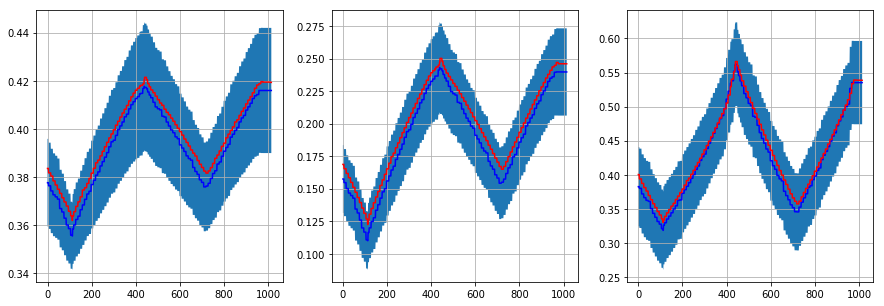

In [23]:
plt.figure(figsize=(15,5))

#1-sigma
sd = np.sqrt(np.array([np.diag(cov) for cov in ee_cov_prior[300:]]))

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(np.array(ee_mean_prior[300:])[:,i],c='b')
    plt.fill_between(np.arange(sd.shape[0]).ravel(),np.array(ee_mean_prior[300:])[:,i].ravel()-sd[:,i].ravel(),np.array(ee_mean_prior[300:])[:,i].ravel()+sd[:,i].ravel())
    plt.plot((X_v[:,i][300:]),c='r')
    #plt.ylim(0,1)
    plt.grid()
plt.show()

In [24]:
ee_image_mu = []
ee_image_uncertain = []
sensor_eeIn2d = []

ee_mean_poster = []
ee_cov_poster = []

for t in range(th_r.shape[0]):
    
    camera_angle = th_c[t,:]
    marker_pos = X_marker[t,:]
    
    mu_theta = th_r[t,:]
    
    #Generate the new sigma points from the ee distribution
    sigma_xee = sigma_points(ee_mean_prior[t].ravel(), ee_cov_prior[t], n_dim, lamda)
    
    #Assign weights to the sigma points
    wsm, wsc = weight_sigma(alpha, n_dim, kappa, beta, lamda) 
    
    
    camHTH = robot.turretTransform(camera_angle)
    ###########check##########################################################################################
    Tcam = np.vstack((np.hstack([Rcam,tcam]),[0,0,0,1]))
    

    #Propagating sigma points through camera model,,check line 31#############################################
    image_eeHomog = np.ones((sigma_xee.shape[0],3))
    for i in range(sigma_xee.shape[0]):
        image_eeHomog[i,:] = rtmapping(sigma_xee[i,:] ,np.linalg.inv(Tcam.dot(np.linalg.inv(camHTH))))
    
    #camHTH - transform base-camera, tcam, 
    #Tcam - transfrom from 
        
    end_effe2D = endEffecImage2d(image_eeHomog)
    
    predictedObservat_mu,predictedUncer_cov = estimate_distri(end_effe2D,wsm, wsc,n_dim,2)
    predictedUncer_cov = predictedUncer_cov + m_noiseQ
    
    ee_image_mu.append(predictedObservat_mu)
    ee_image_uncertain.append(predictedUncer_cov)
    
    
    # #Propagate 3D marker measurement through camera (no rotation and translation)
    sensordata_z = rtmapping(marker_pos, np.eye(4))
    sensordata_in2d = endEffecImage2d(sensordata_z)
    sensor_eeIn2d.append(sensordata_in2d.reshape(2,1))
    
    cross_cov = np.zeros((3,2))
    for i in range(2*(3) + 1):
            cross_cov = cross_cov + wsc[i]*(sigma_xee[i,:].reshape(3,1)
                                         - ee_mean_prior[t].reshape(3,1)).dot((end_effe2D[i,:].reshape(2,1) 
                                                                  - ee_image_mu[t]).T)

    #Compute Kalman gain and the final prediction mean and covariance
    kalman_gain = cross_cov.dot(np.linalg.inv(ee_image_uncertain[t]))
    
###############################################################################################################
    # actual_mu_meas is T to align (2,1) dim, mu_xee is reshaped from 3, to 3,1
    final_predic_mu = ee_mean_prior[t].reshape(3,1) + kalman_gain.dot(sensor_eeIn2d[t].reshape(2,1) - ee_image_mu[t])
    mu_final = np.squeeze(np.asarray(final_predic_mu))
    final_predic_cov = ee_cov_prior[t] - kalman_gain.dot(ee_image_uncertain[t]).dot(kalman_gain.T)
    ee_mean_poster.append(mu_final)
    ee_cov_poster.append(final_predic_cov)
    

In [25]:
ee_mean_prior_test = ee_mean_prior[300:]
ee_mean_poster_test = ee_mean_poster[300:]

ee_cov_prior_test = ee_cov_prior[300:]
ee_cov_poster_test = ee_cov_poster[300:]



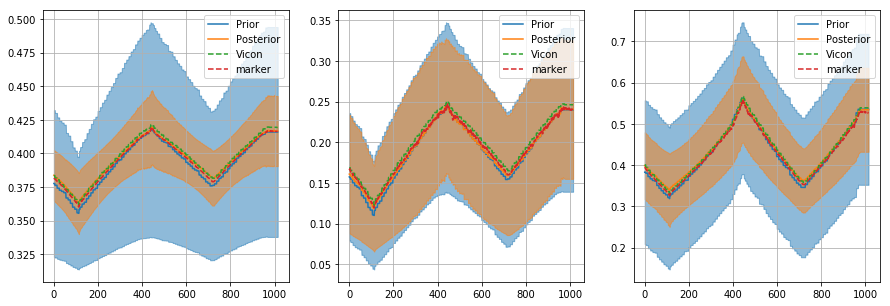

In [26]:
plt.figure(figsize=(15,5))

#1-sigma
sd = np.sqrt(np.array([np.diag(cov) for cov in ee_cov_prior[300:]]))
sd_post = np.sqrt(np.array([np.diag(cov) for cov in ee_cov_poster[300:]]))

for i in range(3):
    plt.subplot(1,3,i+1)
    #####plot the mean prior and its error
    plt.plot(np.array(ee_mean_prior[300:])[:,i],'C0',label='Prior')
    plt.fill_between(np.arange(sd.shape[0]).ravel(),np.array(ee_mean_prior[300:])[:,i].ravel()-3*sd[:,i].ravel(),np.array(ee_mean_prior[300:])[:,i].ravel()+3*sd[:,i].ravel(),color='C0',alpha=0.5)
    
    #####plot the mean posterior and its error
    plt.plot(np.array(ee_mean_poster[300:])[:,i],'C1',label='Posterior')
    plt.fill_between(np.arange(sd_post.shape[0]).ravel(),np.array(ee_mean_poster[300:])[:,i].ravel()-3*sd_post[:,i].ravel(),np.array(ee_mean_poster[300:])[:,i].ravel()+3*sd_post[:,i].ravel(),color='C1',alpha=0.5)
    
    ####plot vicon
    plt.plot(X_v[:,i][300:],'--',color='C2',label='Vicon')
    
    #####plot the 3Dmarker position in the base frame
    plt.plot(X_marker_new[300:][:,i],'--',color='C3',label='marker')
#     plt.plot(X_marker[:,i],'--',color='C3',label='marker')
    
    #plt.ylim(0,1)
    plt.grid()
    
    plt.legend()
plt.show()

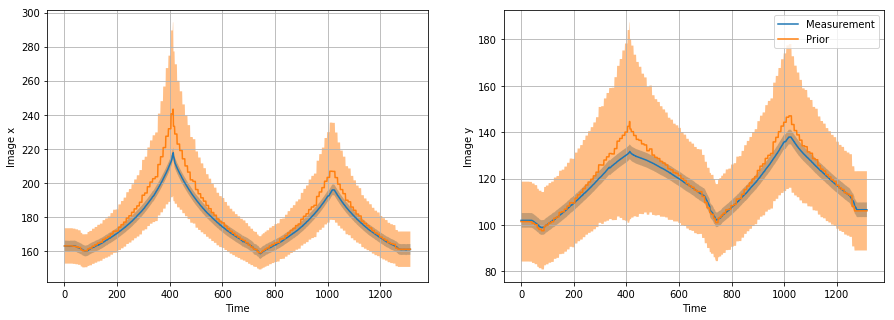

In [27]:
sd = np.array([np.diag(cv) for cv in ee_image_uncertain])

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.array(sensor_eeIn2d)[:,0])
plt.fill_between(np.arange(len(ee_image_mu)),np.array(sensor_eeIn2d)[:,0].ravel()-np.sqrt(m_noiseQ[0,0]).ravel(),np.array(sensor_eeIn2d)[:,0].ravel()+np.sqrt(m_noiseQ[0,0]).ravel(),alpha=0.5)

plt.plot(np.array(ee_image_mu)[:,0])
plt.fill_between(np.arange(len(ee_image_mu)),np.array(ee_image_mu)[:,0].ravel()-np.sqrt(sd[:,0]).ravel(),np.array(ee_image_mu)[:,0].ravel()+np.sqrt(sd[:,0]).ravel(),alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Image x')
plt.grid()

plt.subplot(1,2,2)
plt.plot(np.array(sensor_eeIn2d)[:,1],label='Measurement')
plt.fill_between(np.arange(len(ee_image_mu)),np.array(sensor_eeIn2d)[:,1].ravel()-np.sqrt(m_noiseQ[1,1]).ravel(),np.array(sensor_eeIn2d)[:,1].ravel()+np.sqrt(m_noiseQ[1,1]).ravel(),alpha=0.5)

plt.plot(np.array(ee_image_mu)[:,1],label='Prior')
plt.fill_between(np.arange(len(ee_image_mu)),np.array(ee_image_mu)[:,1].ravel()-np.sqrt(sd[:,1]).ravel(),np.array(ee_image_mu)[:,1].ravel()+np.sqrt(sd[:,1]).ravel(),alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Image y')
plt.legend()
plt.grid()
plt.show()

In [28]:
ee_mean_prior_arra = (np.asanyarray(ee_mean_prior))
ee_mean_prior_arra_squee = np.squeeze(ee_mean_prior_arra, axis=(2,))
ee_cov_prior_arra = (np.asanyarray(ee_cov_prior))

ee_mean_poster_arra = (np.asanyarray(ee_mean_poster))
ee_cov_poster_arra = (np.asanyarray(ee_cov_poster))

##error distribution
prior_error =  ee_mean_prior_arra_squee - X_v
posterior_error = (np.asanyarray(ee_mean_poster)) - X_v
marker_error = X_marker_new - X_v


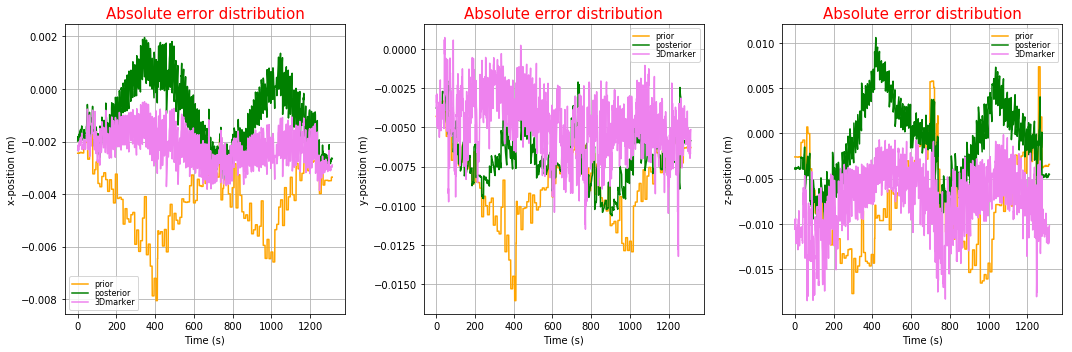

In [29]:
plt.figure(figsize=(15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot((prior_error[:,i]),c='orange', label = 'prior')
    plt.plot(posterior_error[:,i],c='g',label = 'posterior')
    plt.plot((marker_error[:,i]),c='violet',label = '3Dmarker')
    plt.xlabel('Time (s)')
    label_list = ['x-position (m)','y-position (m)','z-position (m)']
    plt.ylabel(label_list[i])
    plt.legend(loc = "best",labelspacing=.000000000009, fontsize = 8)
    plt.title("Absolute error distribution", fontsize = 15,color="red")
    plt.grid()
    plt.tight_layout()
plt.show()

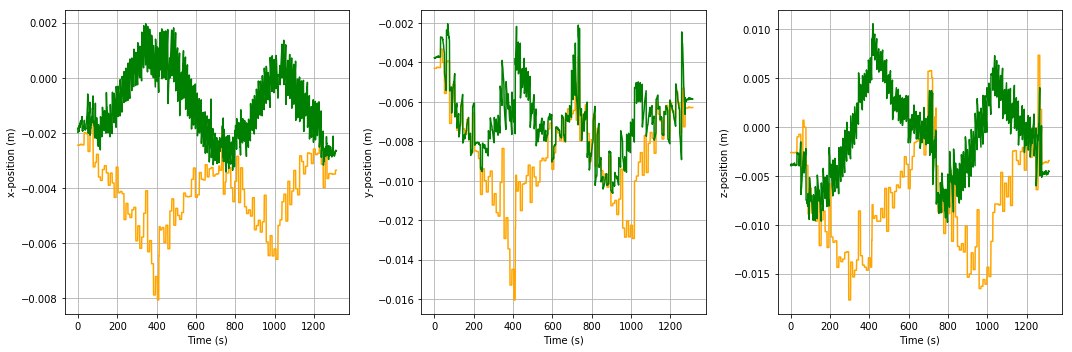

In [30]:
plt.figure(figsize=(15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot((prior_error[:,i]),c='orange')
    plt.plot(posterior_error[:,i],c='g')
    #plt.plot((marker_error[:,i]),c='b')
    plt.xlabel('Time (s)')
    label_list = ['x-position (m)','y-position (m)','z-position (m)']
    plt.ylabel(label_list[i])
    plt.grid()
    plt.tight_layout()
plt.show()

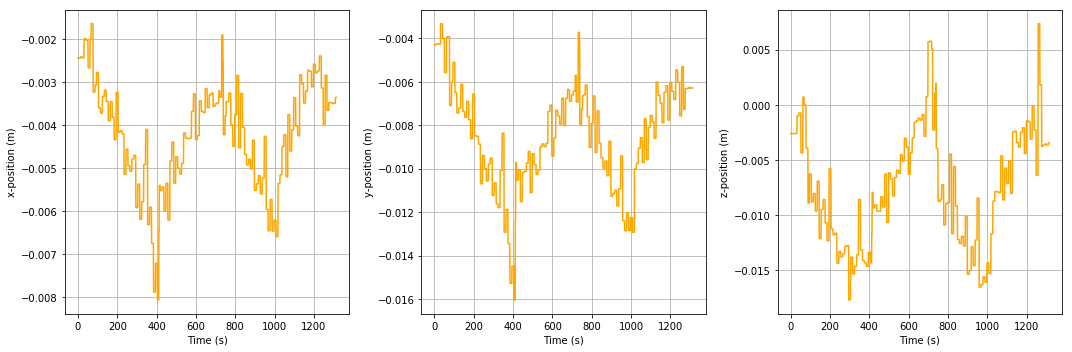

In [31]:
plt.figure(figsize=(15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot((prior_error[:,i]),c='orange')
    plt.grid()
    plt.xlabel('Time (s)')
    label_list = ['x-position (m)','y-position (m)','z-position (m)']
    plt.ylabel(label_list[i])
    plt.tight_layout()
plt.show()

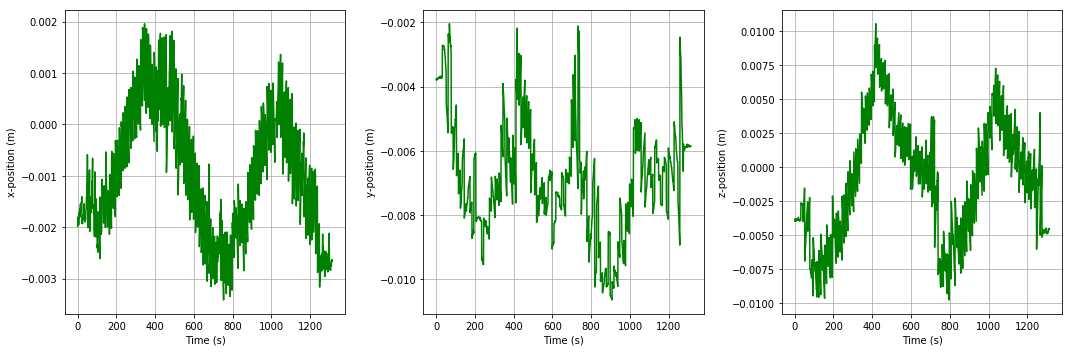

In [32]:
plt.figure(figsize=(15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(posterior_error[:,i],c='g')
    plt.grid()
    plt.xlabel('Time (s)')
    label_list = ['x-position (m)','y-position (m)','z-position (m)']
    plt.ylabel(label_list[i])
    plt.tight_layout()
plt.show()

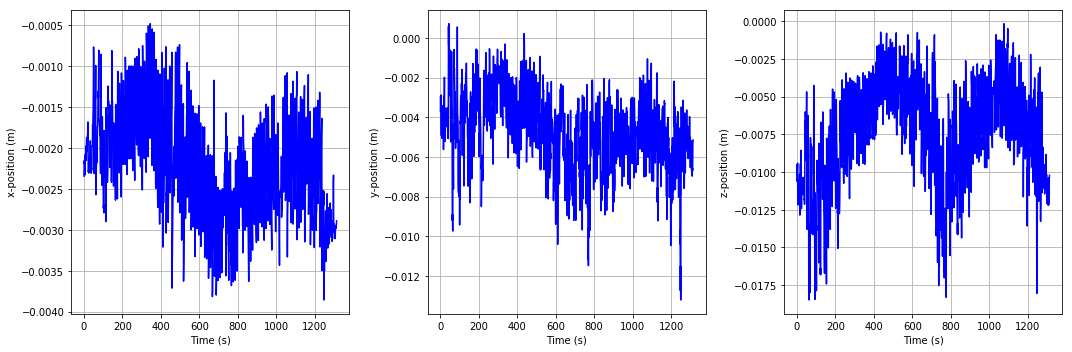

In [33]:
plt.figure(figsize=(15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(marker_error[:,i],c='blue')
    plt.grid()
    plt.xlabel('Time (s)')
    label_list = ['x-position (m)','y-position (m)','z-position (m)']
    plt.ylabel(label_list[i])
    plt.tight_layout()
plt.show()

In [34]:
## #mahalanobis distance and plot ---
mahala_prior_list = []
mahala_poster_list = []
for t in range(len(ee_mean_prior_arra_squee)):
    mahala_prior_list.append(distance.mahalanobis(X_v[t],ee_mean_prior_arra_squee[t],(np.linalg.inv(ee_cov_prior_arra))[t]))
    mahala_poster_list.append(distance.mahalanobis(X_v[t],ee_mean_poster_arra[t],(np.linalg.inv(ee_cov_poster_arra))[t]))
mahala_prior_array = np.asanyarray(mahala_prior_list)
mahala_poster_array = np.asanyarray(mahala_poster_list)

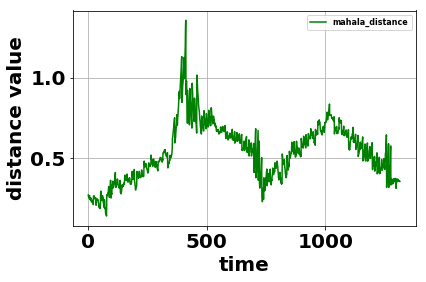

In [64]:
fig = plt.figure()
ax = plt.axes()
#ax.plot(mahala_prior_array, c='orange', label = 'distance before')
ax.plot(mahala_poster_array, c='g', label = 'mahala_distance')
#plt.axhline(y=1, color='b', linestyle='-', label = "benchmark")
#plt.title("Mahalanobis distance before & after measurements",fontsize=15,color="red")
plt.grid()
plt.tight_layout()
plt.xlabel("time")
plt.ylabel("distance value")
plt.legend(loc = "best",labelspacing=.000000000009, fontsize = 8)
plt.show()

In [36]:
#this function computes the kinematics chain of the robot for plotting
def foward_kinematics_plot(joint_angles):
    robot2 = URDF.from_xml_file('robotMarker.urdf')
    links = [rl.name for rl in robot2.links]

    kdl_kin_turret_dy = KDLKinematics(robot2,'base_link','turret_link')
    kdl_kin_shoulder_dy = KDLKinematics(robot2,'base_link','shoulder_link')
    kdl_kin_elbo1_dy= KDLKinematics(robot2,'base_link','elbow1_link')
    kdl_kin_elbo2_dy = KDLKinematics(robot2,'base_link','elbow2_link')
    kdl_kin_ee_dy = KDLKinematics(robot2,'base_link','marker_link')


    base_turretlist_dy = []
    base_shoulderlist_dy = []
    base_elbo1list_dy = []
    base_elbo2list_dy = []
    ee_list_dy = []
    for joints in joint_angles:
        pose_turret_fkmatrix = kdl_kin_turret_dy.forward(joints[:1])
        pose_shoulder_fkmatrix = kdl_kin_shoulder_dy.forward(joints[:2])
        pose_elbo1list_fkmatrix = kdl_kin_elbo1_dy.forward(joints[:2])
        pose_elbo2list_fkmatrix = kdl_kin_elbo2_dy.forward(joints[:3])
        pose_ee_fkmatrix = kdl_kin_ee_dy.forward(joints[:4])

        base_turretlist_dy.append(pose_turret_fkmatrix[0:3,3])
        base_shoulderlist_dy.append(pose_shoulder_fkmatrix[0:3,3])
        base_elbo1list_dy.append(pose_elbo1list_fkmatrix[0:3,3])
        base_elbo2list_dy.append(pose_elbo2list_fkmatrix[0:3,3])
        ee_list_dy.append(pose_ee_fkmatrix[0:3,3])
    
    BaseTo_turret_xyz_dyna = (np.squeeze(np.array(base_turretlist_dy)))    
    BaseTo_shoulder_xyz_dyna = (np.squeeze(np.array(base_shoulderlist_dy)))    
    BaseTo_elbo1_xyz_dyna = (np.squeeze(np.array(base_elbo1list_dy)))
    BaseTo_elbo2_xyz_dyna = (np.squeeze(np.array(base_elbo2list_dy)))
    BaseTo_ee_xyz_dyna = (np.squeeze(np.array(ee_list_dy)))
    
    return BaseTo_turret_xyz_dyna, BaseTo_shoulder_xyz_dyna, BaseTo_elbo1_xyz_dyna, BaseTo_elbo2_xyz_dyna, BaseTo_ee_xyz_dyna


In [45]:
#plotting the chains of the robot to make up the robot model
def robot3D(measurements,axis):
    ax.scatter3D((measurements[0][0]), (measurements[0][1]), (measurements[0][2]), 
                     c='red',s=200, label ='joints',alpha=0.5)
    ax.scatter3D((measurements[1][0]), (measurements[1][1]), (measurements[1][2]),
                     c='red',s=200, label ='joints',alpha=0.5)
    ax.scatter3D((measurements[2][0]), (measurements[2][1]), (measurements[2][2]),
                     c='red',s=200, label ='joints',alpha=0.5)
    ax.scatter3D((measurements[3][0]), (measurements[3][1]), (measurements[3][2]),
                     c='red',s=200, label ='joints',alpha=0.5)
    ax.scatter3D((measurements[4][0]), (measurements[4][1]), (measurements[4][2]),
                     c='red',s=200, label ='joints',alpha=0.5)

    ax.plot3D([measurements[0][0],measurements[1][0]], 
                  [measurements[0][1],measurements[1][1]], 
                  [measurements[0][2],measurements[1][2]],
                  'green',linewidth=9.0, label='links')

    ax.plot3D([measurements[1][0],measurements[2][0]], 
                  [measurements[1][1],measurements[2][1]], 
                  [measurements[1][2],measurements[2][2]],
                  'green',linewidth=9.0, label='links')

    ax.plot3D([measurements[2][0],measurements[3][0]], 
                  [measurements[2][1],measurements[3][1]], 
                  [measurements[2][2],measurements[3][2]], 
                  'green',linewidth=9.0, label='links')
    
    ax.plot3D([measurements[3][0],measurements[4][0]], 
                  [measurements[3][1],measurements[4][1]], 
                  [measurements[3][2],measurements[4][2]], 
                  'green',linewidth=9.0, label='links')

    ax.set_xlabel('X axis', fontsize=16, fontweight='bold', color='red')
    ax.set_ylabel('Y axis',  fontsize=16, fontweight='bold', color='green')
    ax.set_zlabel('Z axis',  fontsize=16, fontweight='bold', color='blue')
    #ax.set_title('3D Manipulator of two links',fontsize = 16, fontweight = 'bold')

In [46]:
tagImagTime_arr = np.asanyarray(tag_imagesTime)
eeMeanPost_arr = np.asanyarray(ee_mean_poster)
eeMeanPrior_arr = (np.asanyarray(ee_mean_prior))
measuments_arr = np.asanyarray(sensor_eeIn2d)
imageplane_measur = np.squeeze(measuments_arr)
ee_meanPriorArray = np.squeeze(eeMeanPrior_arr)

In [47]:
############prior output at image times  
prior_x = np.zeros((tagImagTime_arr.shape[0],ee_meanPriorArray.shape[1]))
for j in range(ee_meanPriorArray.shape[1]):
    f = interpolate.interp1d(t_marker, ee_meanPriorArray[:,j], kind='nearest',fill_value="extrapolate")
    prior_x[:,j] = f(tagImagTime_arr)

############poster output at image times  
poster_x = np.zeros((tagImagTime_arr.shape[0],eeMeanPost_arr.shape[1]))
for j in range(eeMeanPost_arr.shape[1]):
    f = interpolate.interp1d(t_marker, eeMeanPost_arr[:,j], kind='nearest',fill_value="extrapolate")
    poster_x[:,j] = f(tagImagTime_arr)
    
#################2dmeasurement at image times 
image_measurmnts_x = np.zeros((tagImagTime_arr.shape[0],imageplane_measur.shape[1]))
for j in range(imageplane_measur.shape[1]):
    f = interpolate.interp1d(t_marker, imageplane_measur[:,j], kind='nearest',fill_value="extrapolate")
    image_measurmnts_x[:,j] = f(tagImagTime_arr)

In [48]:
th_rTestdata = th_r[300:]
len(th_rTestdata)

1015

In [49]:
#extract theta, the exact mean and cov values to plot the corresponding ellipse for the joints
g_theta1,g_theta2 = th_r[300:][90:110], th_r[300:][690:710]
#select the prior and poster points from the interpolated prior with tag images
g_meanprior1, g_meanprior2 = prior_x[300:][90:110], prior_x[300:][690:710]
g_covprior1, g_covprior2 = ee_cov_prior[300:][90:110], ee_cov_prior[300:][690:710]
#poster 
g_meanposter1, g_meanposter2 = poster_x[300:][90:110], poster_x[300:][690:710]
g_covposter1, g_covposter1 = ee_cov_poster[300:][90:110], ee_cov_poster[300:][690:710]


b_theta1, b_theta2 = th_r[300:][400:410], th_r[300:][500:510]
#prior
b_meanprior1, b_meanprior2 = prior_x[300:][400:410], prior_x[300:][500:510]
b_covprior1, b_covprior2 = ee_cov_prior[300:][400:410], ee_cov_prior[300:][500:510]
#poster
b_meanposter1, b_meanposter2 = poster_x[300:][400:410], poster_x[300:][500:510]
b_covposter1, b_covposter2 = ee_cov_poster[300:][400:410], ee_cov_poster[300:][500:510]

(-0.1, 0.6)

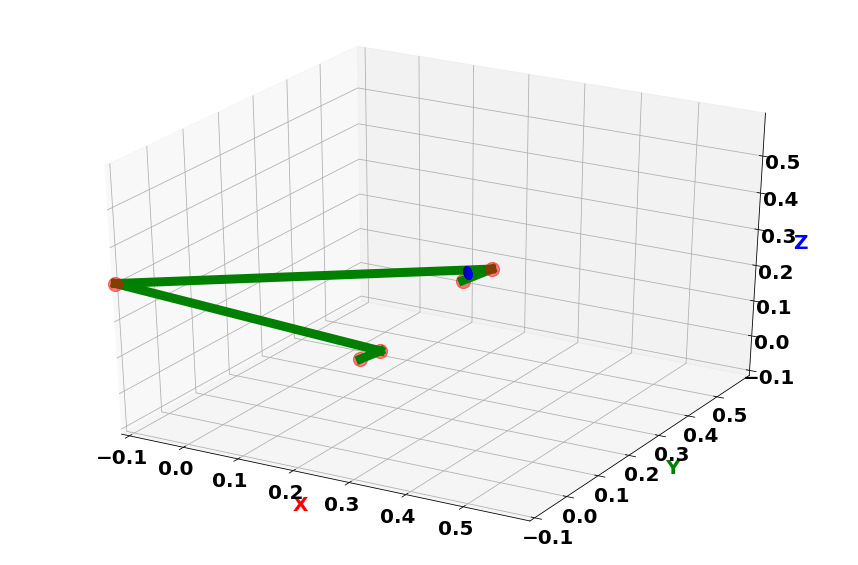

In [52]:
#plot 3D robot model using one theta value and ellipse using prior mean and cov
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
mm = foward_kinematics_plot([g_theta1[4]])
robot3D(mm,ax)
#plot_ellipsoid((g_meanprior1[4]).reshape(3,),g_covprior1[4],ax)
plot_ellipsoid((g_meanposter1[4]).reshape(3,),g_covposter1[4],ax)
ax.set_xlim(-0.1, 0.6)
ax.set_ylim(-0.1, 0.6)
ax.set_zlim(-0.1, 0.6)


In [43]:
from natsort import natsorted
image_list = glob.glob("./Robot_ViconNovember/images/*.png")
numsorted_images = natsorted(image_list)
gr_images = numsorted_images[300:][90:110]
marker_img = gr_images[19]
#marker_img2 = gr_images[12]
plotd_3Deepoint = g_meanprior1[19]
# #Propagate 3D eepoint thru cam model
plotd_3Deepoint_inImagespace = rtmapping(plotd_3Deepoint, np.linalg.inv(Tcam.dot(np.linalg.inv(camHTH))))
plotd_3Deepoint_in2d = (endEffecImage2d(plotd_3Deepoint_inImagespace)).reshape(2,1)

plotd_3Deepoint_po = g_meanposter1[19]
# #Propagate 3D eepoint thru cam model
plotd_3Deepoint_inImagespace_po = rtmapping(plotd_3Deepoint_po, np.linalg.inv(Tcam.dot(np.linalg.inv(camHTH))))
plotd_3Deepoint_in2d_po = (endEffecImage2d(plotd_3Deepoint_inImagespace_po)).reshape(2,1)

In [53]:
sensor = (np.array(sensor_eeIn2d))
cameradata = (np.squeeze(sensor)).T
x,y = cameradata[0,19],cameradata[1,19]


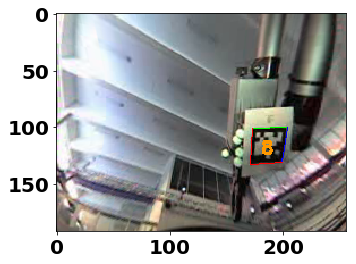

In [66]:
#Plot prior positions on the marker image
image = cv2.imread(marker_img) 
h,w,c = image.shape[:3]
#ee_on_markerimg = cv2.drawMarker(image, ((plotd_3Deepoint_in2d[0]),(plotd_3Deepoint_in2d[1])), color=(255,0,0), markerType=cv2.FONT_HERSHEY_SIMPLEX, 
#markerSize=20, thickness=2)
#measurement_on_markerimg = cv2.drawMarker(image, (int(x),int(y)), color=(0,255,0), markerType=cv2.MARKER_CROSS, thickness=2)

plt.imshow(image)
plt.show()

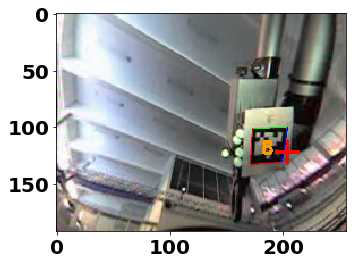

In [55]:

#Plot posterior positions on the marker image
image = cv2.imread(marker_img)   
h,w,c = image.shape[:3]
ee_on_markerimg_po = cv2.drawMarker(image, ((plotd_3Deepoint_in2d_po[0]),(plotd_3Deepoint_in2d_po[1])), color=(255,0,0), markerType=cv2.FONT_HERSHEY_SIMPLEX, 
markerSize=20, thickness=2)

plt.imshow(image)
plt.show()

In [56]:
ee_image_mu_g1 = (ee_image_mu[300:])[90:110]
ee_image_uncertain_g1 = (ee_image_uncertain[300:])[90:110]
sensor_eeIn2d_g1 = (sensor_eeIn2d[300:])[90:110]


/usr/lib/python2.7/dist-packages/matplotlib/axes/_base.py:2961: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=125, right=125
  'left=%s, right=%s') % (left, right))
/usr/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


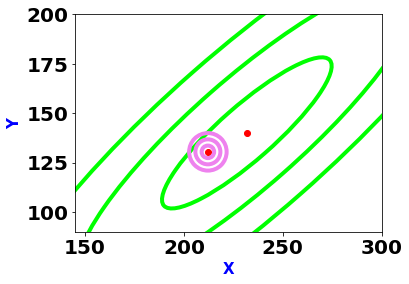

In [57]:
#plot eedistribution obtained by the kinematics vs  the camera distribution 
plot2Dellipse(ee_image_mu_g1[14],ee_image_uncertain_g1[6],ee_image_mu_g1[14], (125,125), (125,140), "lime","red")
plot2Dellipse(sensor_eeIn2d_g1[14].reshape(2,1),m_noiseQ,sensor_eeIn2d_g1[14].reshape(2,1), (145,300), (90,200),"violet","red")

#plt.imshow()
plt.show()

In [58]:
br_images = numsorted_images[300:][500:510]
marker_img2 = br_images[9]

plotd_3Deepoint2 = b_meanprior2[9]
# #Propagate 3D eepoint thru cam model
plotd_3Deepoint_inImagespace2 = rtmapping(plotd_3Deepoint2, np.linalg.inv(Tcam.dot(np.linalg.inv(camHTH))))
plotd_3Deepoint_in2d2 = (endEffecImage2d(plotd_3Deepoint_inImagespace2)).reshape(2,1)

plotd_3Deepoint_po2 = b_meanposter2[9]
# #Propagate 3D eepoint thru cam model
plotd_3Deepoint_inImagespace_po2 = rtmapping(plotd_3Deepoint_po2, np.linalg.inv(Tcam.dot(np.linalg.inv(camHTH))))
plotd_3Deepoint_in2d_po2 = (endEffecImage2d(plotd_3Deepoint_inImagespace_po2)).reshape(2,1)

In [59]:
ee_image_mu = (ee_image_mu)
ee_image_uncertain = (ee_image_uncertain)
sensor_eeIn2d = (sensor_eeIn2d)
sensor3 = (np.array(sensor_eeIn2d))
cameradata2 = (np.squeeze(sensor3)).T
x2,y2 = cameradata2[0,1000],cameradata2[1,1000]


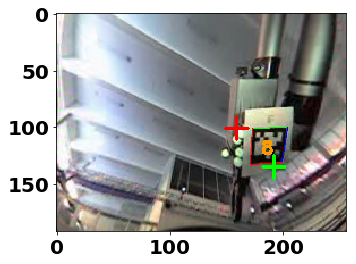

In [60]:
#Plot prior positions on the marker image
image2 = cv2.imread(marker_img)   
h,w,c = image2.shape[:3]
ee_on_markerimg2 = cv2.drawMarker(image2, ((plotd_3Deepoint_in2d2[0]),(plotd_3Deepoint_in2d2[1])), color=(255,0,0), markerType=cv2.FONT_HERSHEY_SIMPLEX, 
markerSize=20, thickness=2)
measurement_on_markerimg2 = cv2.drawMarker(image2, (int(x2),int(y2)), color=(0,255,0), markerType=cv2.MARKER_CROSS, thickness=2)

plt.imshow(image2)
plt.show()

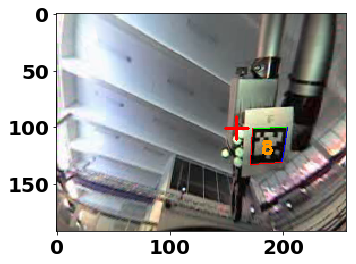

In [61]:
#Plot posterior positions on the marker image
image2 = cv2.imread(marker_img)   
h,w,c = image2.shape[:3]
ee_on_markerimg_po2 = cv2.drawMarker(image2, ((plotd_3Deepoint_in2d_po2[0]),(plotd_3Deepoint_in2d_po2[1])), color=(255,0,0), markerType=cv2.FONT_HERSHEY_SIMPLEX, 
markerSize=20, thickness=2)

plt.imshow(image2)
plt.show()